In [54]:
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [55]:
df = pd.read_csv('SALES_TOKO_FORECAST.csv')
df = df.rename(columns={'HR_DATE': 'date', 'SUM(HR_NET_VALUE)': 'sales'})
df = df.set_index('date')
df.index= pd.to_datetime(df.index)

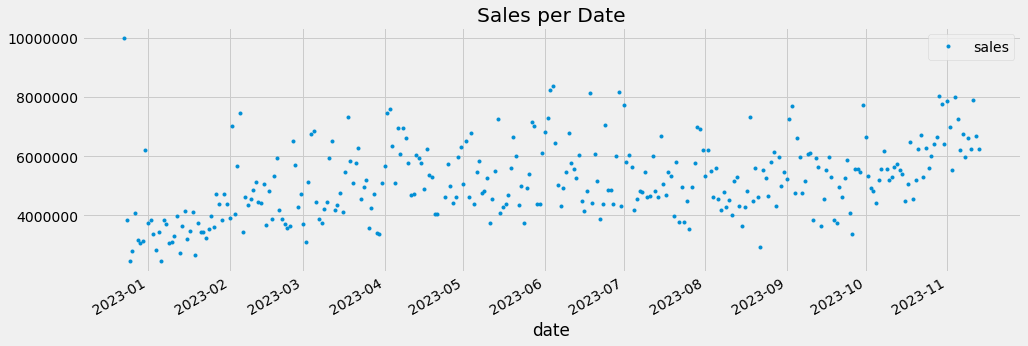

In [56]:
df.plot(style='.',figsize=(15,5),color=color_pal[0],title='Sales per Date').get_yaxis().get_major_formatter().set_scientific(False)

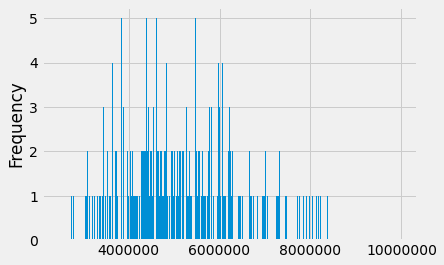

In [57]:
df['sales'].plot(kind='hist',bins=500).get_xaxis().get_major_formatter().set_scientific(False)

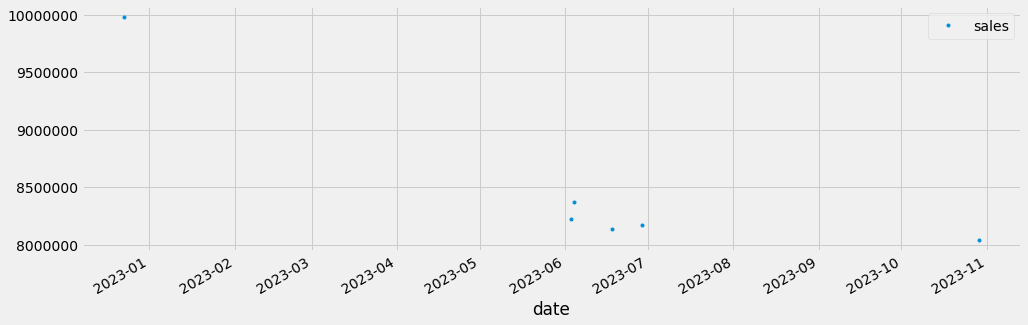

In [58]:
df.query('sales >= 8_000_000').plot(figsize=(15,5),style='.').get_yaxis().get_major_formatter().set_scientific(False)

In [59]:
df = df.query('sales < 8_000_000').copy()

In [61]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=30, gap=0)
df = df.sort_index()

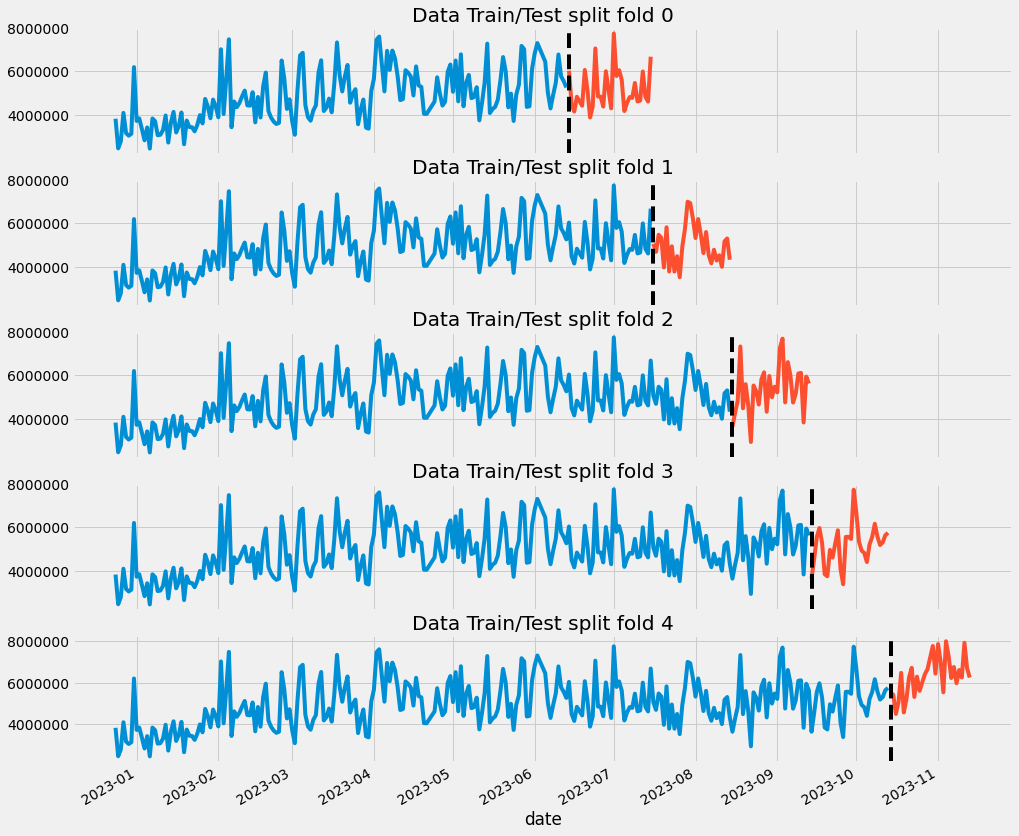

In [62]:
fig,axs = plt.subplots(5,1,figsize=(15,15),sharex=True)
fold = 0
for train_idx, test_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    train['sales'].plot(ax=axs[fold], label = 'training set', title=f'Data Train/Test split fold {fold}')
    test['sales'].plot(ax=axs[fold], label = 'test set').get_yaxis().get_major_formatter().set_scientific(False)
    axs[fold].axvline(test.index.min(),color='black',ls='--')
    fold +=1 

In [63]:
def create_features(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [64]:
def add_lags(df):
    target_map = df['sales'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('28 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('56 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('84 days')).map(target_map)
    return df

df = add_lags(df)

In [65]:
FEATURES = ['dayofyear','dayofweek','quarter','month','year']
TARGET = 'sales'


preds = []
scores = []

for train_idx, test_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    train = create_features(train)
    test = create_features(test)

    x_train = train[FEATURES]
    y_train = train[TARGET]

    x_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score = 0.5,booster='gbtree',n_estimators=1000,early_stopping_rounds=50
                        ,objective = 'reg:linear',max_depth=3,learning_rate=0.01)

    reg.fit(x_train,y_train,
            eval_set =[(x_train,y_train),(x_test,y_test)], 
            verbose=100)


    y_pred= reg.predict(x_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test,y_pred))
    scores.append(score)

[0]	validation_0-rmse:4917711.26102	validation_1-rmse:5208003.63546


[100]	validation_0-rmse:1997960.04707	validation_1-rmse:2004430.45565
[200]	validation_0-rmse:1024121.21833	validation_1-rmse:1000966.32237
[300]	validation_0-rmse:738712.68126	validation_1-rmse:827889.16262
[374]	validation_0-rmse:669931.31396	validation_1-rmse:838647.03376


c:\Users\ardit\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [10:41:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
c:\Users\ardit\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [10:41:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:4962664.47619	validation_1-rmse:5044961.84204
[100]	validation_0-rmse:2006788.93645	validation_1-rmse:2224854.18928
[200]	validation_0-rmse:1031593.13930	validation_1-rmse:1365536.95797
[300]	validation_0-rmse:766569.94889	validation_1-rmse:1138556.51458
[400]	validation_0-rmse:692371.00493	validation_1-rmse:1058010.59728
[500]	validation_0-rmse:654794.95142	validation_1-rmse:1022530.69548
[600]	validation_0-rmse:621860.42512	validation_1-rmse:1004899.58541
[700]	validation_0-rmse:594193.77004	validation_1-rmse:992384.05561
[800]	validation_0-rmse:568578.88996	validation_1-rmse:982434.41096
[900]	validation_0-rmse:546107.69867	validation_1-rmse:977811.88739
[999]	validation_0-rmse:526248.65584	validation_1-rmse:970225.43006
[0]	validation_0-rmse:4971825.66215	validation_1-rmse:5417211.99847
[100]	validation_0-rmse:2008902.41334	validation_1-rmse:2771736.42915
[200]	validation_0-rmse:1036713.46955	validation_1-rmse:1916690.39810
[300]	validation_0-rmse:781440.16710

c:\Users\ardit\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [10:41:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[600]	validation_0-rmse:641715.28336	validation_1-rmse:1490836.76375
[618]	validation_0-rmse:637016.46403	validation_1-rmse:1492075.49149
[0]	validation_0-rmse:5025271.63256	validation_1-rmse:5212707.91514
[100]	validation_0-rmse:2030207.08823	validation_1-rmse:2214366.08224
[200]	validation_0-rmse:1064752.59180	validation_1-rmse:1207875.49556
[300]	validation_0-rmse:808382.19007	validation_1-rmse:981548.44904
[390]	validation_0-rmse:738330.12309	validation_1-rmse:978896.78473


c:\Users\ardit\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [10:41:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
c:\Users\ardit\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [10:41:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation_0-rmse:5045010.01897	validation_1-rmse:6293669.76608
[100]	validation_0-rmse:2029707.90619	validation_1-rmse:3243143.69319
[200]	validation_0-rmse:1059690.18910	validation_1-rmse:2157412.83229
[300]	validation_0-rmse:812830.06860	validation_1-rmse:1791738.91287
[400]	validation_0-rmse:741649.79497	validation_1-rmse:1647478.37008
[500]	validation_0-rmse:700525.18438	validation_1-rmse:1582349.52189
[600]	validation_0-rmse:669887.73632	validation_1-rmse:1538793.81304
[700]	validation_0-rmse:644761.08251	validation_1-rmse:1510265.57702
[800]	validation_0-rmse:621917.71845	validation_1-rmse:1488102.66185
[900]	validation_0-rmse:600813.69353	validation_1-rmse:1477571.25021
[999]	validation_0-rmse:583091.21380	validation_1-rmse:1463519.08530


In [75]:
print(f'{np.mean(scores):0.4f}')
print('fold scores: ',scores)

1143441.3501
fold scores:  [823693.331470123, 970172.2258126246, 1489386.8192403414, 970564.6502474578, 1463389.723528805]


In [ ]:
FEATURES = ['dayofyear','dayofweek','quarter','month','year','lag1','lag2','lag3']
TARGET = 'sales'

x_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score = 0.5,booster='gbtree',n_estimators=1000,early_stopping_rounds=50
                        ,objective = 'reg:linear',max_depth=3,learning_rate=0.01)